In [1]:
#import google drive
from google.colab import drive
drive.mount('/content/drive')

#import necessary libs
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.auto import tqdm #for progress bar used during training

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.mode().iloc[0]

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

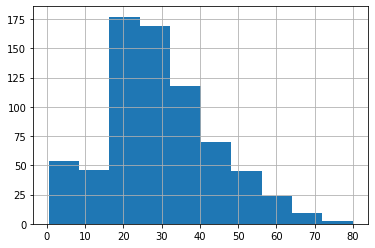

In [5]:
df["Age"].hist()

In [6]:
df.corr('pearson')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


#baseline model:

In [7]:
df.drop(["Cabin","PassengerId","Ticket","Name"],inplace=True,axis=1) #dropping label datasets

In [8]:
#fill na, for numeric data, fill with mean
#save the age mean, for future test.csv
trainAgeMean = df['Age'].mean()
df['Age'] = df['Age'].fillna(trainAgeMean)
#fill na, for categorical data, fill with mode
#save the Embarked mode, for future test.csv
trainEmbarkedMode = df["Embarked"].mode().iloc[0]
df["Embarked"] = df["Embarked"].fillna(trainEmbarkedMode)

In [9]:
print(df.isna().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [10]:
#split x and y
train_X=df.drop('Survived',axis=1)
train_y=df['Survived'].to_numpy()

In [11]:
pre_process_config = {'one-hot-columns':['Sex', 'Embarked'], 
                      'scaler-columns':['Age', 'Fare'],}
#Column transformer, apply one hot to categorical data such as sex and embarked, also apply scaler 
#Additional notes: 
#drop = Specifies a methodology to use to drop one of the categories per feature. if 'first',  then drop first category of each feature
#handle_unknown = Specifies the way unknown categories are handled during transform. Ignore means the one hot encoded result will all be zero
#remainder = using 'passthrough' means column that arent transformed will not be dropped and are left as they were
ct = ColumnTransformer([("one-hot", OneHotEncoder(drop='first',handle_unknown='ignore'),
                         pre_process_config['one-hot-columns']),
                         ("scaler", StandardScaler(),pre_process_config['scaler-columns'])],
                       remainder = 'passthrough')
train_X = ct.fit_transform(train_X) #thre result of this operation is a numpy array
train_X

#only float32 types are accepted in Pytorch datasets format
train_X=train_X.astype('float32')
train_y=train_y.astype('float32')


#make sure the dimension of the y is 2, as expected for pytorch
train_y = train_y.reshape(len(train_y), 1)
print(train_y.shape)
print(train_y.ndim)

(891, 1)
2


In [12]:
#make a class for easy feed to torch model, and also add [] and len functionality for easy access
class ModelDataset(Dataset):
    def __init__(self,x,y):
        self.X = torch.from_numpy(x)
        self.Y = torch.from_numpy((y))
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.Y[item]

train_torch_dataset = ModelDataset(train_X,train_y)
train_torch_dataloader = DataLoader(train_torch_dataset, batch_size=16, shuffle=True, drop_last = True) #recommended batch size  2-128

class TitanicNNModel(torch.nn.Module):
    def __init__(self, n_inputs):
        super(TitanicNNModel, self).__init__()
        self.fc_layer = torch.nn.Sequential(
            torch.nn.Linear(n_inputs, 100),
            torch.nn.ReLU(), 
            torch.nn.Linear(100,150),
            torch.nn.ReLU(),
            torch.nn.Linear(150,1),
            torch.nn.Sigmoid(),
        )

    def forward(self, X):
        result = self.fc_layer(X)
        return result

baseline_model = TitanicNNModel(train_X.shape[1])

In [13]:
epoch_amt = 270

loss_fn = torch.nn.modules.loss.BCELoss() #binary cross entropy, logistic regression function
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.0001)
train_losses = []
for epoch in range(epoch_amt):
    #load the batches in epochs
    current_epoch_loss = 0
    batches = 0
    for idx, batch in enumerate(tqdm(train_torch_dataloader)):
        optimizer.zero_grad() #Sets the gradients of all optimized torch.Tensor s to zero, so that the gradient is not summed between batches
        X, y = batch
        Y_hat = baseline_model(X)
        loss = loss_fn(Y_hat, y)
        loss.backward()
        current_epoch_loss += loss.item()
        batches += 1
        optimizer.step()
    current_epoch_loss /= batches
    print(f"{epoch} epoch's loss mean: {current_epoch_loss}")
    train_losses.append(current_epoch_loss)

  0%|          | 0/55 [00:00<?, ?it/s]

0 epoch's loss mean: 0.6561062021688981


  0%|          | 0/55 [00:00<?, ?it/s]

1 epoch's loss mean: 0.6235785901546478


  0%|          | 0/55 [00:00<?, ?it/s]

2 epoch's loss mean: 0.6045024400407618


  0%|          | 0/55 [00:00<?, ?it/s]

3 epoch's loss mean: 0.5908523619174957


  0%|          | 0/55 [00:00<?, ?it/s]

4 epoch's loss mean: 0.5758425235748291


  0%|          | 0/55 [00:00<?, ?it/s]

5 epoch's loss mean: 0.5650180361487649


  0%|          | 0/55 [00:00<?, ?it/s]

6 epoch's loss mean: 0.55133957862854


  0%|          | 0/55 [00:00<?, ?it/s]

7 epoch's loss mean: 0.536140285838734


  0%|          | 0/55 [00:00<?, ?it/s]

8 epoch's loss mean: 0.5290681692686948


  0%|          | 0/55 [00:00<?, ?it/s]

9 epoch's loss mean: 0.5157816664739089


  0%|          | 0/55 [00:00<?, ?it/s]

10 epoch's loss mean: 0.5094102870334278


  0%|          | 0/55 [00:00<?, ?it/s]

11 epoch's loss mean: 0.4941010605205189


  0%|          | 0/55 [00:00<?, ?it/s]

12 epoch's loss mean: 0.4902115155350078


  0%|          | 0/55 [00:00<?, ?it/s]

13 epoch's loss mean: 0.47859391624277287


  0%|          | 0/55 [00:00<?, ?it/s]

14 epoch's loss mean: 0.471224751255729


  0%|          | 0/55 [00:00<?, ?it/s]

15 epoch's loss mean: 0.46711777665398335


  0%|          | 0/55 [00:00<?, ?it/s]

16 epoch's loss mean: 0.46320247650146484


  0%|          | 0/55 [00:00<?, ?it/s]

17 epoch's loss mean: 0.4569438419558785


  0%|          | 0/55 [00:00<?, ?it/s]

18 epoch's loss mean: 0.45409526391462846


  0%|          | 0/55 [00:00<?, ?it/s]

19 epoch's loss mean: 0.4500830441713333


  0%|          | 0/55 [00:00<?, ?it/s]

20 epoch's loss mean: 0.44578415155410767


  0%|          | 0/55 [00:00<?, ?it/s]

21 epoch's loss mean: 0.4419864099134098


  0%|          | 0/55 [00:00<?, ?it/s]

22 epoch's loss mean: 0.4380937270142815


  0%|          | 0/55 [00:00<?, ?it/s]

23 epoch's loss mean: 0.43859229521317916


  0%|          | 0/55 [00:00<?, ?it/s]

24 epoch's loss mean: 0.4326733413067731


  0%|          | 0/55 [00:00<?, ?it/s]

25 epoch's loss mean: 0.43609377064488153


  0%|          | 0/55 [00:00<?, ?it/s]

26 epoch's loss mean: 0.43196443021297454


  0%|          | 0/55 [00:00<?, ?it/s]

27 epoch's loss mean: 0.4306794564832341


  0%|          | 0/55 [00:00<?, ?it/s]

28 epoch's loss mean: 0.4311636862429706


  0%|          | 0/55 [00:00<?, ?it/s]

29 epoch's loss mean: 0.42538319555195897


  0%|          | 0/55 [00:00<?, ?it/s]

30 epoch's loss mean: 0.42456796792420476


  0%|          | 0/55 [00:00<?, ?it/s]

31 epoch's loss mean: 0.4269996450705962


  0%|          | 0/55 [00:00<?, ?it/s]

32 epoch's loss mean: 0.42776419764215295


  0%|          | 0/55 [00:00<?, ?it/s]

33 epoch's loss mean: 0.4202532364563508


  0%|          | 0/55 [00:00<?, ?it/s]

34 epoch's loss mean: 0.41858520860021764


  0%|          | 0/55 [00:00<?, ?it/s]

35 epoch's loss mean: 0.42092098837549036


  0%|          | 0/55 [00:00<?, ?it/s]

36 epoch's loss mean: 0.4205268234014511


  0%|          | 0/55 [00:00<?, ?it/s]

37 epoch's loss mean: 0.41633282683112405


  0%|          | 0/55 [00:00<?, ?it/s]

38 epoch's loss mean: 0.41333843767642975


  0%|          | 0/55 [00:00<?, ?it/s]

39 epoch's loss mean: 0.4173064448616721


  0%|          | 0/55 [00:00<?, ?it/s]

40 epoch's loss mean: 0.41613384756174954


  0%|          | 0/55 [00:00<?, ?it/s]

41 epoch's loss mean: 0.41636323820460924


  0%|          | 0/55 [00:00<?, ?it/s]

42 epoch's loss mean: 0.4161097063259645


  0%|          | 0/55 [00:00<?, ?it/s]

43 epoch's loss mean: 0.41391723399812524


  0%|          | 0/55 [00:00<?, ?it/s]

44 epoch's loss mean: 0.41172783320600337


  0%|          | 0/55 [00:00<?, ?it/s]

45 epoch's loss mean: 0.4156851922923868


  0%|          | 0/55 [00:00<?, ?it/s]

46 epoch's loss mean: 0.4140974453904412


  0%|          | 0/55 [00:00<?, ?it/s]

47 epoch's loss mean: 0.40733173110268334


  0%|          | 0/55 [00:00<?, ?it/s]

48 epoch's loss mean: 0.40917893783612685


  0%|          | 0/55 [00:00<?, ?it/s]

49 epoch's loss mean: 0.40998891673304816


  0%|          | 0/55 [00:00<?, ?it/s]

50 epoch's loss mean: 0.4098634671081196


  0%|          | 0/55 [00:00<?, ?it/s]

51 epoch's loss mean: 0.4062961635264483


  0%|          | 0/55 [00:00<?, ?it/s]

52 epoch's loss mean: 0.40636622526428917


  0%|          | 0/55 [00:00<?, ?it/s]

53 epoch's loss mean: 0.40438010232015087


  0%|          | 0/55 [00:00<?, ?it/s]

54 epoch's loss mean: 0.40376123054461044


  0%|          | 0/55 [00:00<?, ?it/s]

55 epoch's loss mean: 0.40546141131357716


  0%|          | 0/55 [00:00<?, ?it/s]

56 epoch's loss mean: 0.3991425348953767


  0%|          | 0/55 [00:00<?, ?it/s]

57 epoch's loss mean: 0.40665702738545156


  0%|          | 0/55 [00:00<?, ?it/s]

58 epoch's loss mean: 0.4039837349544872


  0%|          | 0/55 [00:00<?, ?it/s]

59 epoch's loss mean: 0.4019227003509348


  0%|          | 0/55 [00:00<?, ?it/s]

60 epoch's loss mean: 0.399393661997535


  0%|          | 0/55 [00:00<?, ?it/s]

61 epoch's loss mean: 0.4029454540122639


  0%|          | 0/55 [00:00<?, ?it/s]

62 epoch's loss mean: 0.4035028861327605


  0%|          | 0/55 [00:00<?, ?it/s]

63 epoch's loss mean: 0.4007677145979621


  0%|          | 0/55 [00:00<?, ?it/s]

64 epoch's loss mean: 0.4011560246348381


  0%|          | 0/55 [00:00<?, ?it/s]

65 epoch's loss mean: 0.4007819254289974


  0%|          | 0/55 [00:00<?, ?it/s]

66 epoch's loss mean: 0.3982632192698392


  0%|          | 0/55 [00:00<?, ?it/s]

67 epoch's loss mean: 0.39889054460959


  0%|          | 0/55 [00:00<?, ?it/s]

68 epoch's loss mean: 0.39982721548188815


  0%|          | 0/55 [00:00<?, ?it/s]

69 epoch's loss mean: 0.3938389317555861


  0%|          | 0/55 [00:00<?, ?it/s]

70 epoch's loss mean: 0.39895026114853943


  0%|          | 0/55 [00:00<?, ?it/s]

71 epoch's loss mean: 0.3965804544362155


  0%|          | 0/55 [00:00<?, ?it/s]

72 epoch's loss mean: 0.3943738853389567


  0%|          | 0/55 [00:00<?, ?it/s]

73 epoch's loss mean: 0.39405188289555637


  0%|          | 0/55 [00:00<?, ?it/s]

74 epoch's loss mean: 0.3963064879179001


  0%|          | 0/55 [00:00<?, ?it/s]

75 epoch's loss mean: 0.3940481868657199


  0%|          | 0/55 [00:00<?, ?it/s]

76 epoch's loss mean: 0.39414746327833694


  0%|          | 0/55 [00:00<?, ?it/s]

77 epoch's loss mean: 0.39442603994499553


  0%|          | 0/55 [00:00<?, ?it/s]

78 epoch's loss mean: 0.39238253588026223


  0%|          | 0/55 [00:00<?, ?it/s]

79 epoch's loss mean: 0.38912055654959243


  0%|          | 0/55 [00:00<?, ?it/s]

80 epoch's loss mean: 0.39329346445473756


  0%|          | 0/55 [00:00<?, ?it/s]

81 epoch's loss mean: 0.39215067625045774


  0%|          | 0/55 [00:00<?, ?it/s]

82 epoch's loss mean: 0.3908869903195988


  0%|          | 0/55 [00:00<?, ?it/s]

83 epoch's loss mean: 0.3872684706341137


  0%|          | 0/55 [00:00<?, ?it/s]

84 epoch's loss mean: 0.3892373290928927


  0%|          | 0/55 [00:00<?, ?it/s]

85 epoch's loss mean: 0.39032314013351094


  0%|          | 0/55 [00:00<?, ?it/s]

86 epoch's loss mean: 0.39094423841346393


  0%|          | 0/55 [00:00<?, ?it/s]

87 epoch's loss mean: 0.3908128936182369


  0%|          | 0/55 [00:00<?, ?it/s]

88 epoch's loss mean: 0.3871730612082915


  0%|          | 0/55 [00:00<?, ?it/s]

89 epoch's loss mean: 0.3878542875701731


  0%|          | 0/55 [00:00<?, ?it/s]

90 epoch's loss mean: 0.3881718085570769


  0%|          | 0/55 [00:00<?, ?it/s]

91 epoch's loss mean: 0.387754810127345


  0%|          | 0/55 [00:00<?, ?it/s]

92 epoch's loss mean: 0.386902839216319


  0%|          | 0/55 [00:00<?, ?it/s]

93 epoch's loss mean: 0.386502698876641


  0%|          | 0/55 [00:00<?, ?it/s]

94 epoch's loss mean: 0.38463661128824406


  0%|          | 0/55 [00:00<?, ?it/s]

95 epoch's loss mean: 0.38657815835692666


  0%|          | 0/55 [00:00<?, ?it/s]

96 epoch's loss mean: 0.3849364903840152


  0%|          | 0/55 [00:00<?, ?it/s]

97 epoch's loss mean: 0.3816931036385623


  0%|          | 0/55 [00:00<?, ?it/s]

98 epoch's loss mean: 0.3837679464708675


  0%|          | 0/55 [00:00<?, ?it/s]

99 epoch's loss mean: 0.381528428196907


  0%|          | 0/55 [00:00<?, ?it/s]

100 epoch's loss mean: 0.38302534249695863


  0%|          | 0/55 [00:00<?, ?it/s]

101 epoch's loss mean: 0.38209347426891327


  0%|          | 0/55 [00:00<?, ?it/s]

102 epoch's loss mean: 0.38532137897881596


  0%|          | 0/55 [00:00<?, ?it/s]

103 epoch's loss mean: 0.37935967635024676


  0%|          | 0/55 [00:00<?, ?it/s]

104 epoch's loss mean: 0.3810538118535822


  0%|          | 0/55 [00:00<?, ?it/s]

105 epoch's loss mean: 0.3828305407003923


  0%|          | 0/55 [00:00<?, ?it/s]

106 epoch's loss mean: 0.37929009334607555


  0%|          | 0/55 [00:00<?, ?it/s]

107 epoch's loss mean: 0.3827033200047233


  0%|          | 0/55 [00:00<?, ?it/s]

108 epoch's loss mean: 0.3815409986810251


  0%|          | 0/55 [00:00<?, ?it/s]

109 epoch's loss mean: 0.3780136823654175


  0%|          | 0/55 [00:00<?, ?it/s]

110 epoch's loss mean: 0.37771619151939045


  0%|          | 0/55 [00:00<?, ?it/s]

111 epoch's loss mean: 0.3747366720979864


  0%|          | 0/55 [00:00<?, ?it/s]

112 epoch's loss mean: 0.37849084707823666


  0%|          | 0/55 [00:00<?, ?it/s]

113 epoch's loss mean: 0.37736148075623943


  0%|          | 0/55 [00:00<?, ?it/s]

114 epoch's loss mean: 0.37646796811710703


  0%|          | 0/55 [00:00<?, ?it/s]

115 epoch's loss mean: 0.3779934815385125


  0%|          | 0/55 [00:00<?, ?it/s]

116 epoch's loss mean: 0.3795304761691527


  0%|          | 0/55 [00:00<?, ?it/s]

117 epoch's loss mean: 0.3782431701367552


  0%|          | 0/55 [00:00<?, ?it/s]

118 epoch's loss mean: 0.3772710182450034


  0%|          | 0/55 [00:00<?, ?it/s]

119 epoch's loss mean: 0.376688872684132


  0%|          | 0/55 [00:00<?, ?it/s]

120 epoch's loss mean: 0.37510582262819464


  0%|          | 0/55 [00:00<?, ?it/s]

121 epoch's loss mean: 0.37511445446447894


  0%|          | 0/55 [00:00<?, ?it/s]

122 epoch's loss mean: 0.372502799467607


  0%|          | 0/55 [00:00<?, ?it/s]

123 epoch's loss mean: 0.37801443284208125


  0%|          | 0/55 [00:00<?, ?it/s]

124 epoch's loss mean: 0.3764420287175612


  0%|          | 0/55 [00:00<?, ?it/s]

125 epoch's loss mean: 0.37119972705841064


  0%|          | 0/55 [00:00<?, ?it/s]

126 epoch's loss mean: 0.37194793143055654


  0%|          | 0/55 [00:00<?, ?it/s]

127 epoch's loss mean: 0.3715721848336133


  0%|          | 0/55 [00:00<?, ?it/s]

128 epoch's loss mean: 0.3759773842313073


  0%|          | 0/55 [00:00<?, ?it/s]

129 epoch's loss mean: 0.3729413165287538


  0%|          | 0/55 [00:00<?, ?it/s]

130 epoch's loss mean: 0.36931350935589186


  0%|          | 0/55 [00:00<?, ?it/s]

131 epoch's loss mean: 0.3731646004048261


  0%|          | 0/55 [00:00<?, ?it/s]

132 epoch's loss mean: 0.373328916051171


  0%|          | 0/55 [00:00<?, ?it/s]

133 epoch's loss mean: 0.3702718030322682


  0%|          | 0/55 [00:00<?, ?it/s]

134 epoch's loss mean: 0.37317164025523447


  0%|          | 0/55 [00:00<?, ?it/s]

135 epoch's loss mean: 0.3710145565596494


  0%|          | 0/55 [00:00<?, ?it/s]

136 epoch's loss mean: 0.37069086649201133


  0%|          | 0/55 [00:00<?, ?it/s]

137 epoch's loss mean: 0.37278467118740083


  0%|          | 0/55 [00:00<?, ?it/s]

138 epoch's loss mean: 0.37209253880110654


  0%|          | 0/55 [00:00<?, ?it/s]

139 epoch's loss mean: 0.37154381952502513


  0%|          | 0/55 [00:00<?, ?it/s]

140 epoch's loss mean: 0.37057480188933284


  0%|          | 0/55 [00:00<?, ?it/s]

141 epoch's loss mean: 0.36935231414708225


  0%|          | 0/55 [00:00<?, ?it/s]

142 epoch's loss mean: 0.3691104826602069


  0%|          | 0/55 [00:00<?, ?it/s]

143 epoch's loss mean: 0.3676610296422785


  0%|          | 0/55 [00:00<?, ?it/s]

144 epoch's loss mean: 0.36616402837363154


  0%|          | 0/55 [00:00<?, ?it/s]

145 epoch's loss mean: 0.3668952977115458


  0%|          | 0/55 [00:00<?, ?it/s]

146 epoch's loss mean: 0.363906262002208


  0%|          | 0/55 [00:00<?, ?it/s]

147 epoch's loss mean: 0.3635933434421366


  0%|          | 0/55 [00:00<?, ?it/s]

148 epoch's loss mean: 0.360933011228388


  0%|          | 0/55 [00:00<?, ?it/s]

149 epoch's loss mean: 0.36926342276009644


  0%|          | 0/55 [00:00<?, ?it/s]

150 epoch's loss mean: 0.36888088109818373


  0%|          | 0/55 [00:00<?, ?it/s]

151 epoch's loss mean: 0.3657872481779619


  0%|          | 0/55 [00:00<?, ?it/s]

152 epoch's loss mean: 0.36347853920676493


  0%|          | 0/55 [00:00<?, ?it/s]

153 epoch's loss mean: 0.3668068308721889


  0%|          | 0/55 [00:00<?, ?it/s]

154 epoch's loss mean: 0.3663600719787858


  0%|          | 0/55 [00:00<?, ?it/s]

155 epoch's loss mean: 0.3662250754508105


  0%|          | 0/55 [00:00<?, ?it/s]

156 epoch's loss mean: 0.3610492167147723


  0%|          | 0/55 [00:00<?, ?it/s]

157 epoch's loss mean: 0.3667967622930353


  0%|          | 0/55 [00:00<?, ?it/s]

158 epoch's loss mean: 0.3649183078245683


  0%|          | 0/55 [00:00<?, ?it/s]

159 epoch's loss mean: 0.362571901624853


  0%|          | 0/55 [00:00<?, ?it/s]

160 epoch's loss mean: 0.36357067146084526


  0%|          | 0/55 [00:00<?, ?it/s]

161 epoch's loss mean: 0.3656780565326864


  0%|          | 0/55 [00:00<?, ?it/s]

162 epoch's loss mean: 0.3634847873991186


  0%|          | 0/55 [00:00<?, ?it/s]

163 epoch's loss mean: 0.3631277447397059


  0%|          | 0/55 [00:00<?, ?it/s]

164 epoch's loss mean: 0.358243667808446


  0%|          | 0/55 [00:00<?, ?it/s]

165 epoch's loss mean: 0.3645196949893778


  0%|          | 0/55 [00:00<?, ?it/s]

166 epoch's loss mean: 0.362224556370215


  0%|          | 0/55 [00:00<?, ?it/s]

167 epoch's loss mean: 0.3631255821748213


  0%|          | 0/55 [00:00<?, ?it/s]

168 epoch's loss mean: 0.36327339356595817


  0%|          | 0/55 [00:00<?, ?it/s]

169 epoch's loss mean: 0.36030949679288


  0%|          | 0/55 [00:00<?, ?it/s]

170 epoch's loss mean: 0.36027529727328905


  0%|          | 0/55 [00:00<?, ?it/s]

171 epoch's loss mean: 0.3611168113621798


  0%|          | 0/55 [00:00<?, ?it/s]

172 epoch's loss mean: 0.3600722674619068


  0%|          | 0/55 [00:00<?, ?it/s]

173 epoch's loss mean: 0.3613079006021673


  0%|          | 0/55 [00:00<?, ?it/s]

174 epoch's loss mean: 0.3607053607702255


  0%|          | 0/55 [00:00<?, ?it/s]

175 epoch's loss mean: 0.35759132314812053


  0%|          | 0/55 [00:00<?, ?it/s]

176 epoch's loss mean: 0.3579918387261304


  0%|          | 0/55 [00:00<?, ?it/s]

177 epoch's loss mean: 0.35545198741284284


  0%|          | 0/55 [00:00<?, ?it/s]

178 epoch's loss mean: 0.35324596789750184


  0%|          | 0/55 [00:00<?, ?it/s]

179 epoch's loss mean: 0.3568743671883236


  0%|          | 0/55 [00:00<?, ?it/s]

180 epoch's loss mean: 0.36027168103239754


  0%|          | 0/55 [00:00<?, ?it/s]

181 epoch's loss mean: 0.36053173677487804


  0%|          | 0/55 [00:00<?, ?it/s]

182 epoch's loss mean: 0.3541787618940527


  0%|          | 0/55 [00:00<?, ?it/s]

183 epoch's loss mean: 0.35544931915673345


  0%|          | 0/55 [00:00<?, ?it/s]

184 epoch's loss mean: 0.35795940282669936


  0%|          | 0/55 [00:00<?, ?it/s]

185 epoch's loss mean: 0.35250999846241693


  0%|          | 0/55 [00:00<?, ?it/s]

186 epoch's loss mean: 0.35838072774085133


  0%|          | 0/55 [00:00<?, ?it/s]

187 epoch's loss mean: 0.35590149055827747


  0%|          | 0/55 [00:00<?, ?it/s]

188 epoch's loss mean: 0.35407086448235947


  0%|          | 0/55 [00:00<?, ?it/s]

189 epoch's loss mean: 0.3555473579601808


  0%|          | 0/55 [00:00<?, ?it/s]

190 epoch's loss mean: 0.3537179426713423


  0%|          | 0/55 [00:00<?, ?it/s]

191 epoch's loss mean: 0.35673536306077785


  0%|          | 0/55 [00:00<?, ?it/s]

192 epoch's loss mean: 0.3557272106409073


  0%|          | 0/55 [00:00<?, ?it/s]

193 epoch's loss mean: 0.3568688430569389


  0%|          | 0/55 [00:00<?, ?it/s]

194 epoch's loss mean: 0.3529455287890001


  0%|          | 0/55 [00:00<?, ?it/s]

195 epoch's loss mean: 0.35777967355468054


  0%|          | 0/55 [00:00<?, ?it/s]

196 epoch's loss mean: 0.3533324184742841


  0%|          | 0/55 [00:00<?, ?it/s]

197 epoch's loss mean: 0.35534527816555717


  0%|          | 0/55 [00:00<?, ?it/s]

198 epoch's loss mean: 0.35313052833080294


  0%|          | 0/55 [00:00<?, ?it/s]

199 epoch's loss mean: 0.35328971567479045


  0%|          | 0/55 [00:00<?, ?it/s]

200 epoch's loss mean: 0.3575176621025259


  0%|          | 0/55 [00:00<?, ?it/s]

201 epoch's loss mean: 0.35312105783007364


  0%|          | 0/55 [00:00<?, ?it/s]

202 epoch's loss mean: 0.3553021723573858


  0%|          | 0/55 [00:00<?, ?it/s]

203 epoch's loss mean: 0.3525011542168531


  0%|          | 0/55 [00:00<?, ?it/s]

204 epoch's loss mean: 0.3455923920327967


  0%|          | 0/55 [00:00<?, ?it/s]

205 epoch's loss mean: 0.3520712958140807


  0%|          | 0/55 [00:00<?, ?it/s]

206 epoch's loss mean: 0.34986937533725393


  0%|          | 0/55 [00:00<?, ?it/s]

207 epoch's loss mean: 0.3494103876027194


  0%|          | 0/55 [00:00<?, ?it/s]

208 epoch's loss mean: 0.3497660420157693


  0%|          | 0/55 [00:00<?, ?it/s]

209 epoch's loss mean: 0.34953979524699125


  0%|          | 0/55 [00:00<?, ?it/s]

210 epoch's loss mean: 0.3489670105955818


  0%|          | 0/55 [00:00<?, ?it/s]

211 epoch's loss mean: 0.3529981875961477


  0%|          | 0/55 [00:00<?, ?it/s]

212 epoch's loss mean: 0.3512414040890607


  0%|          | 0/55 [00:00<?, ?it/s]

213 epoch's loss mean: 0.3519676612182097


  0%|          | 0/55 [00:00<?, ?it/s]

214 epoch's loss mean: 0.35163629976185884


  0%|          | 0/55 [00:00<?, ?it/s]

215 epoch's loss mean: 0.35035452409224077


  0%|          | 0/55 [00:00<?, ?it/s]

216 epoch's loss mean: 0.3493941634893417


  0%|          | 0/55 [00:00<?, ?it/s]

217 epoch's loss mean: 0.3486054549163038


  0%|          | 0/55 [00:00<?, ?it/s]

218 epoch's loss mean: 0.34613180526278237


  0%|          | 0/55 [00:00<?, ?it/s]

219 epoch's loss mean: 0.3499024465680122


  0%|          | 0/55 [00:00<?, ?it/s]

220 epoch's loss mean: 0.3465076870538972


  0%|          | 0/55 [00:00<?, ?it/s]

221 epoch's loss mean: 0.3492344774983146


  0%|          | 0/55 [00:00<?, ?it/s]

222 epoch's loss mean: 0.34977855411442843


  0%|          | 0/55 [00:00<?, ?it/s]

223 epoch's loss mean: 0.3461574987931685


  0%|          | 0/55 [00:00<?, ?it/s]

224 epoch's loss mean: 0.3485943241552873


  0%|          | 0/55 [00:00<?, ?it/s]

225 epoch's loss mean: 0.34708442782813853


  0%|          | 0/55 [00:00<?, ?it/s]

226 epoch's loss mean: 0.34896242943677036


  0%|          | 0/55 [00:00<?, ?it/s]

227 epoch's loss mean: 0.3498756674203006


  0%|          | 0/55 [00:00<?, ?it/s]

228 epoch's loss mean: 0.34311983964659953


  0%|          | 0/55 [00:00<?, ?it/s]

229 epoch's loss mean: 0.34913733872500335


  0%|          | 0/55 [00:00<?, ?it/s]

230 epoch's loss mean: 0.3496520687233318


  0%|          | 0/55 [00:00<?, ?it/s]

231 epoch's loss mean: 0.3467759756879373


  0%|          | 0/55 [00:00<?, ?it/s]

232 epoch's loss mean: 0.34797640348022635


  0%|          | 0/55 [00:00<?, ?it/s]

233 epoch's loss mean: 0.34666531627828423


  0%|          | 0/55 [00:00<?, ?it/s]

234 epoch's loss mean: 0.3435972064733505


  0%|          | 0/55 [00:00<?, ?it/s]

235 epoch's loss mean: 0.34663779220797797


  0%|          | 0/55 [00:00<?, ?it/s]

236 epoch's loss mean: 0.3507759232412685


  0%|          | 0/55 [00:00<?, ?it/s]

237 epoch's loss mean: 0.34551342265172436


  0%|          | 0/55 [00:00<?, ?it/s]

238 epoch's loss mean: 0.3479001753709533


  0%|          | 0/55 [00:00<?, ?it/s]

239 epoch's loss mean: 0.34862145693464713


  0%|          | 0/55 [00:00<?, ?it/s]

240 epoch's loss mean: 0.3434812316840345


  0%|          | 0/55 [00:00<?, ?it/s]

241 epoch's loss mean: 0.3470502640713345


  0%|          | 0/55 [00:00<?, ?it/s]

242 epoch's loss mean: 0.3475274534388022


  0%|          | 0/55 [00:00<?, ?it/s]

243 epoch's loss mean: 0.3403602670539509


  0%|          | 0/55 [00:00<?, ?it/s]

244 epoch's loss mean: 0.3458436052907597


  0%|          | 0/55 [00:00<?, ?it/s]

245 epoch's loss mean: 0.3466316429051486


  0%|          | 0/55 [00:00<?, ?it/s]

246 epoch's loss mean: 0.3468312753872438


  0%|          | 0/55 [00:00<?, ?it/s]

247 epoch's loss mean: 0.3470032261176543


  0%|          | 0/55 [00:00<?, ?it/s]

248 epoch's loss mean: 0.3435653660785068


  0%|          | 0/55 [00:00<?, ?it/s]

249 epoch's loss mean: 0.3480661294677041


  0%|          | 0/55 [00:00<?, ?it/s]

250 epoch's loss mean: 0.34175627610900183


  0%|          | 0/55 [00:00<?, ?it/s]

251 epoch's loss mean: 0.34737365530295805


  0%|          | 0/55 [00:00<?, ?it/s]

252 epoch's loss mean: 0.3440271643075076


  0%|          | 0/55 [00:00<?, ?it/s]

253 epoch's loss mean: 0.34390053992921654


  0%|          | 0/55 [00:00<?, ?it/s]

254 epoch's loss mean: 0.3416368714787743


  0%|          | 0/55 [00:00<?, ?it/s]

255 epoch's loss mean: 0.3467310390689156


  0%|          | 0/55 [00:00<?, ?it/s]

256 epoch's loss mean: 0.3449625161561099


  0%|          | 0/55 [00:00<?, ?it/s]

257 epoch's loss mean: 0.34350407909263264


  0%|          | 0/55 [00:00<?, ?it/s]

258 epoch's loss mean: 0.345959211750464


  0%|          | 0/55 [00:00<?, ?it/s]

259 epoch's loss mean: 0.3401029123501344


  0%|          | 0/55 [00:00<?, ?it/s]

260 epoch's loss mean: 0.3412176923318343


  0%|          | 0/55 [00:00<?, ?it/s]

261 epoch's loss mean: 0.34144999411973087


  0%|          | 0/55 [00:00<?, ?it/s]

262 epoch's loss mean: 0.33894909484819935


  0%|          | 0/55 [00:00<?, ?it/s]

263 epoch's loss mean: 0.339716068722985


  0%|          | 0/55 [00:00<?, ?it/s]

264 epoch's loss mean: 0.3437874443151734


  0%|          | 0/55 [00:00<?, ?it/s]

265 epoch's loss mean: 0.3425480833107775


  0%|          | 0/55 [00:00<?, ?it/s]

266 epoch's loss mean: 0.34036037759347393


  0%|          | 0/55 [00:00<?, ?it/s]

267 epoch's loss mean: 0.3414865006100048


  0%|          | 0/55 [00:00<?, ?it/s]

268 epoch's loss mean: 0.3370042320002209


  0%|          | 0/55 [00:00<?, ?it/s]

269 epoch's loss mean: 0.34235377609729767


##predict the test csv

In [14]:
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic/test.csv')
test.drop(["Cabin","PassengerId","Ticket","Name"],inplace=True,axis=1)
test['Age']=test['Age'].fillna(trainAgeMean)
test['Embarked']=test['Embarked'].fillna(trainEmbarkedMode)
test=ct.transform(test)
test=test.astype('float32')
test=torch.from_numpy(test)

with torch.no_grad():
    Y_predict = baseline_model(test) #no_grad mode since we don't want to train model

Y_predict = Y_predict.numpy()
Y_predict = Y_predict[:,0]
Y_predict = np.where(Y_predict > 0.5, 1, 0)

In [15]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic/gender_submission.csv')
submission['Survived'] = Y_predict
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/Titanic/submission.csv',index=False)